In [1]:
import os
os.environ['PYSR_AUTOLOAD_EXTENSIONS'] = 'no'
from matplotlib import pyplot as plt
from interpret import paretoize, overall_complexity, number_of_variables_in_expression
from utils import load_pickle
%matplotlib inline
SPLIT = 'test'
# SPLIT = 'random'
# SPLIT = 'val'

/home/sca63/.conda/envs/new_bnn/lib/python3.7/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  "torch was imported before juliacall. This may cause a segfault. "


In [2]:
version = 11003
# version = 93102
results_path = f'sr_results/{version}.pkl'
reg = load_pickle(results_path)
# results = reg.equations_[0]
results = reg.equations_

In [3]:
d = {2: {'version': 24880,
         'pysr_version': 93102},
     3: {'version': 74649,
         'pysr_version': 49636},
     4: {'version': 11566,
         'pysr_version': 94842},
     5: {'version': 72646,
         'pysr_version': 42503}}

f2_linear_models = {
    0: 4014,
    2: 22649,
    5: 13523,
    10: 22697,
    20: 8880,
}

# f2_linear_models = {
#     20: 2702,
#     10: 13529,
#     5: 7307,
#     2: 22160,
#     0: 4014,
# }

# d = {2: {'version': 24880,
#          'pysr_version': 11003},
#      3: {'version': 74649,
#          'pysr_version': 83278},
#      4: {'version': 11566,
#          'pysr_version': 51254},
#      5: {'version': 72646,
#          'pysr_version': 55894}}


In [4]:
k_results = {}
for k, v in d.items():
    # load the original PySR table
    pysr_version = v['pysr_version']
    version = v['version']
    pysr_results = load_pickle(f'sr_results/{pysr_version}.pkl').equations_
    try:
        all_rmses = load_pickle(f'pickles/pysr_results_all_{version}_{pysr_version}.pkl')[SPLIT]
    except FileNotFoundError:
        print(f'File not found for {version} and {pysr_version}')
    except KeyError:
        print(f'Key not found for {version} and {pysr_version}')
        continue

    results = {}
    for comp in all_rmses.keys():
        eq = pysr_results[pysr_results['complexity'] == comp].iloc[0]
        overall_comp = overall_complexity(eq, k)
        results[overall_comp] = all_rmses[comp]

    k_results[k] = results

In [ ]:
def nn_test_rmse(version):
    return load_pickle(f'pickles/nn_results_all_{version}.pkl')[SPLIT]

# calculate overall complexity
def overall_complexity_f2_linear(n_features):
    '''
    - each feature is mean/std of a k=2 input feature, which has complexity 2.
    - we do a linear combination of the features, so that is complexity 3 * n_features (2 for each feature, 1 for the product)
    - also we have a bias term, which adds 1
    '''
    return 3 * n_features + 1


f2_linear_results = {
    overall_complexity_f2_linear(k): nn_test_rmse(v) for k, v in f2_linear_models.items()
}

# f1_id_results = load_pickle('pickles/pysr_results_all_28114_50620.pkl')[SPLIT]
# f1_id_results = load_pickle('pickles/pysr_results_all_28114_50620.pkl')[SPLIT]
f1_id_results = load_pickle('pickles/pysr_results_all_28114_93890.pkl')[SPLIT]
# f1_id_results = load_pickle('pickles/pysr_results_all_28114_9054.pkl')[SPLIT]

pure_sr_results = load_pickle('pickles/pure_sr_results_all_83941.pkl')[SPLIT]
# get rid of entries with rmse over 2.0, because they were probably invalid equations
pure_sr_results = {k: v for k, v in pure_sr_results.items() if v < 2.0}

In [6]:
def plot_k(k_results):
    plt.rcParams["font.family"] = "serif"
    plt.figure(figsize=(6, 4))
    ax = plt.gca()

    # plot k results
    for k in k_results:
        result = k_results[k]
        x, y = zip(*result.items())
        x, y = paretoize(x, y, replace=False)
        label = f'$k = {k}$' if k != 2 else '$k = 2$ (Ours)'
        ax.plot(x, y, marker='^', label=label)

    ax.set_xlabel('Overall complexity', fontsize=14, labelpad=10)
    ax.set_ylabel('RMSE (Resonant)', fontsize=14, labelpad=10)
    ax.legend()
    plt.tight_layout()
    plt.savefig('graphics/top_k_pareto.png', dpi=400, bbox_inches='tight')
    plt.show()


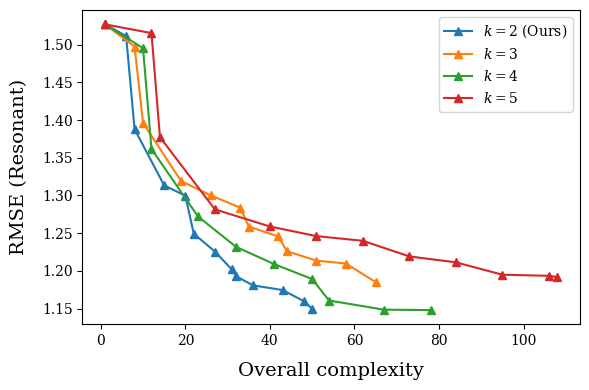

In [7]:
plot_k(k_results)

In [13]:
def plot_all():
    plt.rcParams["font.family"] = "serif"
    plt.figure(figsize=(6, 4))
    ax = plt.gca()

    # # plot k results
    # for k in k_results:
    #     result = k_results[k]
    #     x, y = zip(*result.items())
    #     x, y = paretoize(x, y, replace=False)
    #     label = f'$k = {k}$' if k != 2 else '$k = 2$ (Ours)'
    #     ax.plot(x, y, marker='^', label=label)

    # plot k=2 results
    k = 2
    result = k_results[k]
    x, y = zip(*result.items())
    x, y = paretoize(x, y, replace=False)
    ax.plot(x, y, marker='^', label='Ours')

    # add f2 linear results
    x, y = zip(*f2_linear_results.items())
    x, y = paretoize(x, y, replace=False)
    ax.plot(x, y, marker='o', label='Linear $\psi$')

    # add f1 id results
    x, y = zip(*f1_id_results.items())
    # x, y = paretoize(x, y, replace=False)
    ax.plot(x, y, marker='o', label='Pure SR (no intermediate features)')

    # add pure SR results
    x, y = zip(*pure_sr_results.items())
    x, y = paretoize(x, y, replace=False)
    # ax.plot(x, y, marker='o', label='Pure SR w/ learned features')
    ax.plot(x, y, marker='o', label='Pure SR')

    ax.set_xlabel('Overall complexity', fontsize=14, labelpad=10)
    ax.set_ylabel('RMSE (Resonant)', fontsize=14, labelpad=10)
    ax.legend()
    plt.tight_layout()
    plt.savefig('graphics/comparison_pareto.png', dpi=400, bbox_inches='tight')
    plt.show()

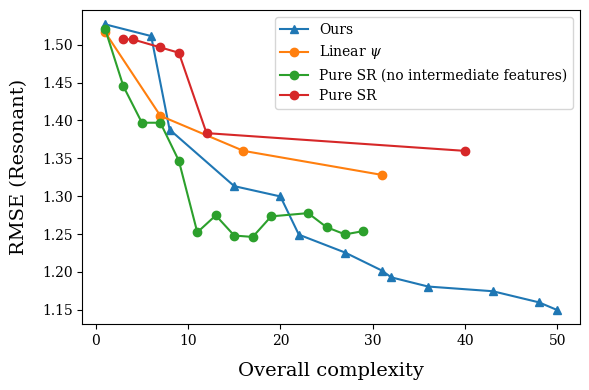

In [14]:
plot_all()

In [10]:
def plot_combined_pareto(
    k_results,
    f2_linear_results,
    pure_sr_results,
    path,
):
    """
    Combine the `plot_k` and `plot_all` panels into one stacked figure and save it.

    Parameters
    ----------
    k_results
        Mapping k -> {complexity: rmse}.
    f2_linear_results
        Mapping {complexity: rmse} for the “Linear ψ” baseline.
    pure_sr_results
        Mapping {complexity: rmse} for the “Pure SR” baseline.
    path
        Destination path.
    """
    plt.rcParams["font.family"] = "serif"

    # --- Layout ------------------------------------------------------------
    fig, axs = plt.subplots(
        nrows = 2,
        ncols = 1,
        figsize = (6, 8),
        sharex = False,
        # constrained_layout = True,
        gridspec_kw={"hspace": 0.25}
    )

    # ---------- Top panel: all k -------------------------------------------
    ax = axs[0]
    for k, result in k_results.items():
        x, y = zip(*result.items())
        x, y = paretoize(x, y, replace=False)
        label = f"$k = {k}$" if k != 2 else "$k = 2$ (Ours)"
        ax.plot(x, y, marker = "^", label = label)

    first_line = ax.lines[0]     # or keep a handle returned by ax.plot
    first_line.set_zorder(10)    # any value larger than the others

    ax.set_xlabel("Overall complexity", fontsize = 12, labelpad = 6)
    ax.set_ylabel("RMSE (Resonant)", fontsize = 12, labelpad = 6)
    # ax.set_title("Top‑k Pareto fronts", fontsize = 14, pad = 8)
    ax.legend()

    # ---------- Bottom panel: comparison -----------------------------------
    ax = axs[1]

    # k = 2 (ours)
    x, y = zip(*k_results[2].items())
    x, y = paretoize(x, y, replace=False)
    ax.plot(x, y, marker = "^", label = "Ours")

    # linear ψ baseline
    x, y = zip(*f2_linear_results.items())
    x, y = paretoize(x, y, replace=False)
    ax.plot(x, y, marker = "o", label = "Linear $\\psi$")

    # pure SR baseline
    x, y = zip(*pure_sr_results.items())
    x, y = paretoize(x, y, replace=False)
    ax.plot(x, y, marker = "o", label = "Pure SR")

    first_line = ax.lines[0]     # or keep a handle returned by ax.plot
    first_line.set_zorder(10)    # any value larger than the others

    ax.set_xlabel("Overall complexity", fontsize = 12, labelpad = 6)
    ax.set_ylabel("RMSE (Resonant)", fontsize = 12, labelpad = 6)
    # ax.set_title("Baselines vs. ours", fontsize = 14, pad = 8)
    ax.legend()

    # --- Save & return ------------------------------------------------------
    fig.savefig(path, bbox_inches = "tight", dpi = 400)
    plt.close(fig)
    return fig, axs

In [11]:
plot_combined_pareto(
    k_results,
    f2_linear_results,
    pure_sr_results,
    path = "graphics/pareto_comparison.pdf"
)

(<Figure size 600x800 with 2 Axes>,
 array([<AxesSubplot:xlabel='Overall complexity', ylabel='RMSE (Resonant)'>,
        <AxesSubplot:xlabel='Overall complexity', ylabel='RMSE (Resonant)'>],
       dtype=object))